In [ ]:
!sudo pip3 install docplex
!sudo pip3 install pulp

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model

## setting parameters:

In [ ]:
np.random.seed(0)
n=5 #num of clients
m=7 #maximum size of order
Q=10 #vehicle capacity
N=[i for i in range(1,n+1)] #clients
V=[0]+N #verticles with central point
q={i:np.random.randint(1,m+1) for i in N} #liczba sztuk do dostarczenia
x=np.random.rand(len(V))#*200
y=np.random.rand(len(V))#*200
print(V)

[0, 1, 2, 3, 4, 5]


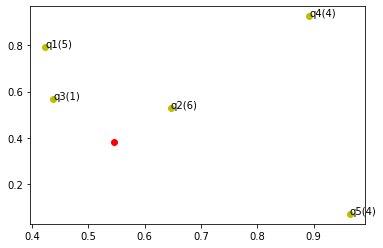

In [ ]:
plt.scatter(x[1:],y[1:],c='y')
for i in N:
    plt.annotate('q{}({})'.format(i, q[i]), (x[i],y[i]))
plt.scatter(x[0],y[0],c='r')

## adding decision variables 
(dict or Pandas)

* dictionary keys are decision variables
* values are decision variable objects 

*A decision variable is defined with three main properties:* 
* *its type (continuous, binary or integer),* 
* *its lower bound (0 by default),* 
* *its upper bound (infinity by default).*

here: decision variable is distance (proportional to the cost)

In [ ]:
p=[(i,j) for i in V for j in V if i!=j] #all posible routes  
d={(i,j): np.hypot([x[i]-x[j]],[y[i]-y[j]])[0] for (i,j) in p} #distances
#np.hypot calculates hypotenuse == sqrt(a^2+b^2)

## adding decision variables to the model

In [ ]:
cModel=Model('Cplex VRP')
X = cModel.binary_var_dict(p, name='X')
U = cModel.continuous_var_dict(N, ub=Q, name='u') #quantity picked up?
#ontinuous decision variables???

## adding objective
mathematical formula:

$$\begin{align}
\min \sum_{i \in V} \sum_{j \in V} d_{ij} x_{ij} \\
\end{align}$$

In [ ]:
#cModel.minimize(cModel.sum(d[i,j]*X[i,j] for (i,j) in p)) 
objective = cModel.sum(d[i,j]*X[i,j] for (i,j) in p)
cModel.minimize(objective)

## seting constraints

*Any constraint has three parts:*
* *a left-hand side (normally a linear combination of decision variables),*
* *a right-hand side (usually a numeric value),*
* *a sense (Less than or equal, Equal, or Greater than or equal)*


* one way ticket:

$$\begin{align}
\qquad \sum_{j \in V, j\neq i} x_{ij}  = 1 && i \in N \\

\text{hej} \\
\qquad \sum_{i \in V, i\neq j} x_{ij}  = 1 && j \in N \\
\end{align}$$
* transit load constraints i.e., if arc (i, j) is visited by the vehicle v, then the quantity picked-up has to increase by pj 

$$\begin{align}
\qquad (U_i + q_i - U_j)X_{ij} = 0  && i,j \in p : i \neq 0, j \neq 0 \\
\end{align}$$
* ensuring that the load on vehicle, when departing from node i, is always lower than the vehicle capacity (basically a constrain for X=1): 

$$\begin{align}
\qquad q_i+U_i \leq && i \in N \\
 \end{align}$$

In [ ]:
cModel.add_constraints(cModel.sum(X[i,j] for j in V if j!=i)==1 for i in N)
#od punktu i (z wyjątkiem zera) może pojechać do jednego punktu j 
cModel.add_constraints(cModel.sum(X[i,j] for i in V if j!=i)==1 for j in N)
#od punktu j (z wyjątkiem zera) może pojechać do jednego punktu i
cModel.add_indicator_constraints(cModel.indicator_constraint(X[i, j], U[i]+q[j] == U[j]) for i, j in p 
                                 if i!=0 and j!=0) #(15)
cModel.add_constraints(U[i] >= q[i] for i in N) #(11)

[docplex.mp.LinearConstraint[](u_1,GE,5),
 docplex.mp.LinearConstraint[](u_2,GE,6),
 docplex.mp.LinearConstraint[](u_3,GE,1),
 docplex.mp.LinearConstraint[](u_4,GE,4),
 docplex.mp.LinearConstraint[](u_5,GE,4)]

## finding the solution

In [ ]:
solution=cModel.solve(log_output=True)

colab nie liczy cplexem więc dane poniżej oraz plot pochodzą z obliczeń komputera dla tego samego ziarna

solution for: Cplex VRP

objective: 2.82503

X_0_4=1

X_0_5=1

X_1_3=1

X_2_0=1

X_3_0=1

X_4_1=1

X_5_2=1

u_1=9.000

u_2=10.000

u_3=10.000

u_5=4.000

## solution plot

In [ ]:
active = [a for a in p if X[a].solution_value ==1] #>0.9

In [ ]:
plt.scatter(x[1:],y[1:],c='c')
for i in N:
    plt.annotate('q{}({})'.format(i, q[i]), (x[i],y[i]))
for (i,j) in active:
    plt.plot([x[i],x[j]],[y[i],y[j]],c='y')
plt.scatter(x[0],y[0],c='r')

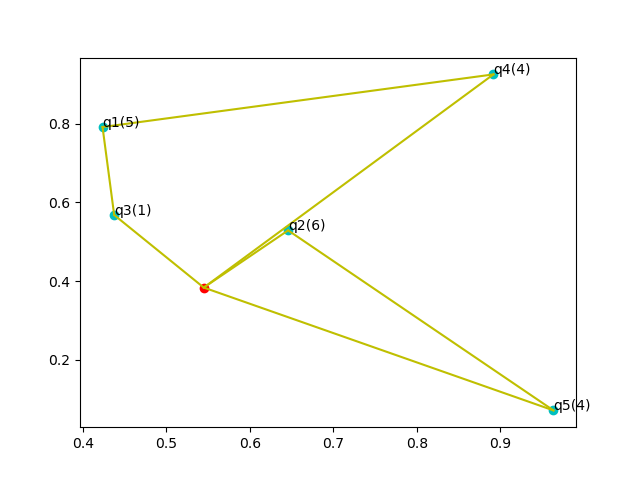